In [1]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
from pandas_datareader import data

In [2]:
import powerlaw

# Simulation

In [3]:
from stockmarket import baselinemodel

In [4]:
#%prun baselinemodel.stockMarketSimulation(seed=0, simulation_time=10, amount_momentum=40, amount_mean_reversion=40, amount_firms=1,initial_money=(100, 200),initial_bid_ask=(1,1), initial_memory=(3,7),initial_ma_short=(2,3), initial_ma_long=(6,7),initial_profit=(200,200),initial_book_value=(10000, 10000),initial_stock_amount=400,order_expiration_time=120,init_propensity_to_switch=1.1,init_price_to_earnings_window=(6, 12),firm_profit_mu=0.058,firm_profit_delta=0.00396825396,firm_profit_sigma=0.125,printProgress=False)

In [56]:
SIMTIME = 500

In [57]:
agents, firms, stocks, order_books, market_maker = baselinemodel.stockMarketSimulation(seed=0, simulation_time=SIMTIME,
                                                                                       amount_momentum=0,
                                                                                       amount_mean_reversion=0,
                                                                                       amount_noise_traders=100,
                                                                                       amount_firms=1,
                                                                                       initial_money=(100, 200),
                                                                                       initial_bid_ask=(1,1),
                                                                                       initial_memory=(3,7),
                                                                                       initial_ma_short=(20,40),
                                                                                       initial_ma_long=(120,150),
                                                                                       initial_profit=(200,200),
                                                                                       initial_book_value=(10000, 10000),
                                                                                       initial_stock_amount=4000,
                                                                                       order_expiration_time=150,
                                                                                       init_propensity_to_switch=1.1,
                                                                                       init_price_to_earnings_window=((4, 7), (10, 14)),
                                                                                       firm_profit_mu=0.058,
                                                                                       firm_profit_delta=0.00396825396,
                                                                                       firm_profit_sigma=0.125,
                                                                                       profit_announcement_working_days=20,
                                                                                       agents_hold_thresholds=(0.9995, 1.0005),
                                                                                       init_share_of_stocks_to_market_maker=0.4,
                                                                                       init_backward_simulated_time=200,
                                                                                       trader_volume_risk_aversion=0.1,
                                                                                       order_variability=1.5,
                                                                                       printProgress=False
                                                                                       )

# Quick results

## Firm profits

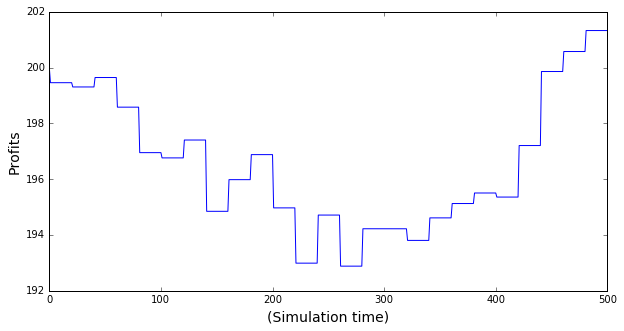

In [58]:
profits = firms[0].profit_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(profits)), profits)

ax1.set_ylabel('Profits', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

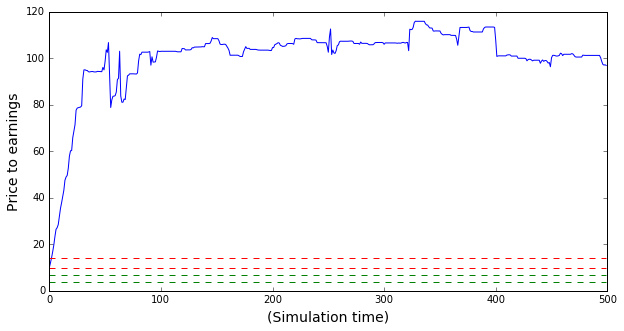

In [59]:
price_to_earnings = stocks[0].price_to_earnings_history

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(price_to_earnings)), price_to_earnings)
ax1.plot(range(len(price_to_earnings)), [4 for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [7 for x in range(len(price_to_earnings))], 'g--')
ax1.plot(range(len(price_to_earnings)), [10 for x in range(len(price_to_earnings))], 'r--')
ax1.plot(range(len(price_to_earnings)), [14 for x in range(len(price_to_earnings))], 'r--')
#ax1.plot(range(len(price_to_earnings)), )

#ax1.set_ylim(0, 16)

ax1.set_ylabel('Price to earnings', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

# Buy and sell orders

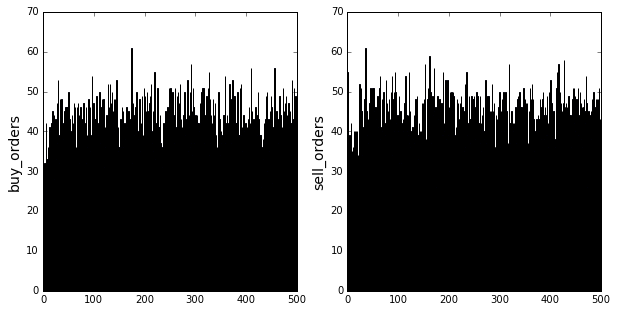

In [60]:
buy_orders = order_books[0].buy_orders_history
sell_orders = order_books[0].sell_orders_history
#sell_orders

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(range(len(buy_orders)), buy_orders)
ax2.bar(range(len(sell_orders)), sell_orders)


ax1.set_ylabel('buy_orders', fontsize='14')
ax2.set_ylabel('sell_orders', fontsize='14')

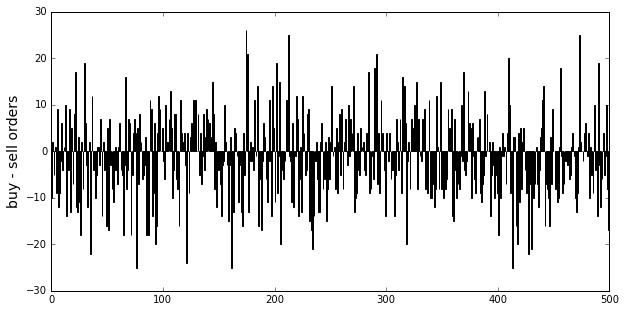

In [61]:
buy_minus_sell_orders = np.array(buy_orders) - np.array(sell_orders)

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(buy_minus_sell_orders)), buy_minus_sell_orders)


ax1.set_ylabel('buy - sell orders', fontsize='14')

# Market Prices and Volume

In [62]:
prices = order_books[0].transaction_prices_history
averageprices = []
for day in prices:
    averageprices.append(np.mean(day))

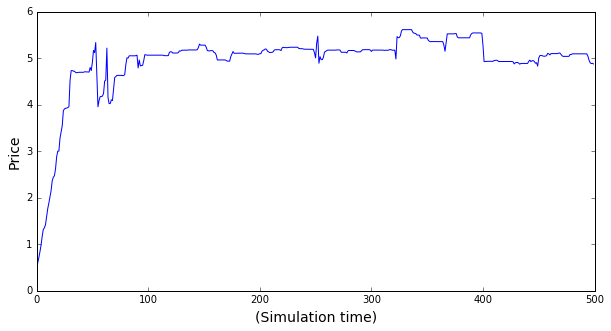

In [63]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(averageprices)), averageprices)

ax1.set_ylabel('Price', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

In [48]:
volume = order_books[0].transaction_volumes_history
totalvolume = []
for day in volume:
    totalvolume.append(sum(day))

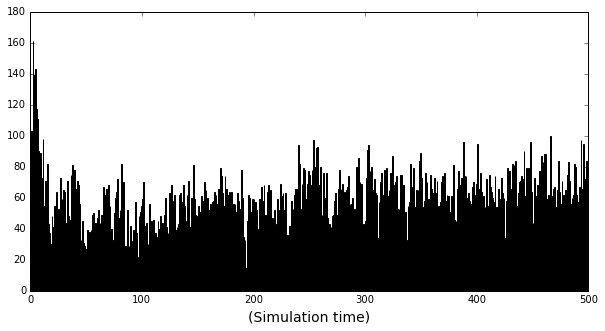

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.bar(range(len(totalvolume)), totalvolume)

ax1.set_xlabel('(Simulation time)', fontsize='14')

## Intraday prices

In [50]:
all_transaction_prices = order_books[0].transaction_prices_history

In [51]:
all_transaction_prices = list(itertools.chain.from_iterable(all_transaction_prices))

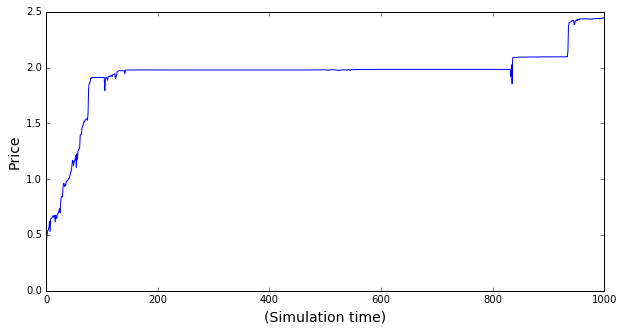

In [52]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

zoomed_prices = all_transaction_prices[:1000]

ax1.plot(range(len(zoomed_prices)), zoomed_prices)

ax1.set_ylabel('Price', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

# Strategy switching

In [53]:
def percentageMomentum(period, agents):
    momentum = 0
    queryString = 'momentum'
    for agent in agents:
        function = str(agent.function_history[period])
        if queryString in function:
            momentum += 1
    return momentum / (len(agents))

In [54]:
percFund = []
for period in range(SIMTIME):
    percFund.append(percentageMomentum(period, agents))

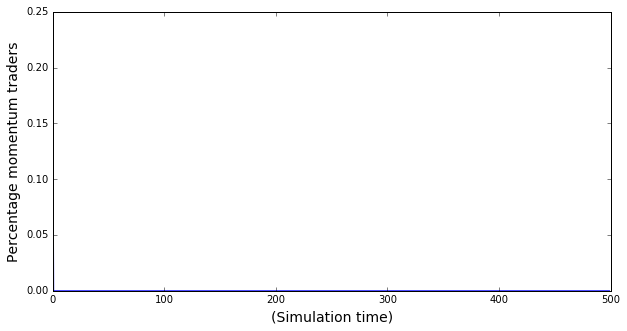

In [55]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(percFund)), percFund)

ax1.set_ylabel('Percentage momentum traders', fontsize='14')
ax1.set_xlabel('(Simulation time)', fontsize='14')

## Actual s&p 500 data

In [56]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']
spy_returns = spy.pct_change()[1:]

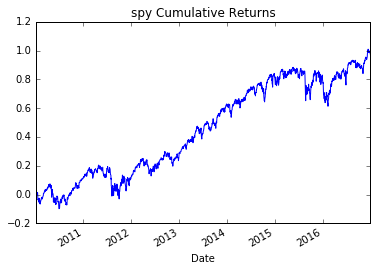

In [53]:
((1 + spy_returns).cumprod() - 1).plot(title='spy Cumulative Returns')

# Stylized facts

Most of the text comes from: Rama Cont (2001) Journal of Quantitative Finance

How to replicate these? 
* centrifugal forces (for volatility clusering and fat tails) = mean reversion, trend following & fundamental component)
* very low autocorrelation? ... stochasticity? 
* large positive autocorrelation in volume? 

In [70]:
# return autocorrelation close to zero after lag 1
# calculate returns 
def calculate_close(orderbook_transaction_price_history):
    closing_prices = []
    for day in orderbook_transaction_price_history:
        closing_prices.append(day[-1])
    close = pd.Series(closing_prices).pct_change()
    return close

def calculate_returns(orderbook_transaction_price_history):
    """Return the returns"""
    closing_prices = []
    for day in orderbook_transaction_price_history:
        closing_prices.append(day[-1])
    returns = pd.Series(closing_prices).pct_change()
    return returns[1:]

# Test 1
def zero_autocorrelation(returns, lags):
    """returns wether average autocorrelation is much different from zero"""
    autocorr_returns = [returns.autocorr(lag=lag) for lag in range(lags)]
    # if mean autocorrelation are between -0.1 and 0.1
    average_autocorrelation = np.mean(autocorr_returns[1:])
    if (average_autocorrelation < 0.1) and (average_autocorrelation > -0.1):
        return True
    else:
        return False

# Test 2 
def fat_tails(returns):
    results = powerlaw.Fit(returns)
    alpha = results.power_law.alpha
    print(alpha)
    if (alpha < 4) and (alpha > 2):
        return True
    else:
        return False
    
# Test 3
def clustered_volatility(returns, lags):
    absolute_returns = returns.abs()
    autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(lags)]
    average_autocorrelation = np.mean(autocorr_abs_returns[1:])
    print(average_autocorrelation)
    if (average_autocorrelation < 0.1) and (average_autocorrelation > -0.1):
        return False
    else:
        return True

# Test 4
def non_linear_dependence(returns, hurst_function, lag1, lag2):
    h = hurst_function(returns, lag1, lag2)
    print(h)
    if (h > 0.55) or (h < 0.45):
        return True
    else: 
        return False

In [93]:
# test 1
zero_autocorrelation(calculate_returns(order_books[0].transaction_prices_history), 25)

True

In [94]:
zero_autocorrelation(spy_returns, 25)

True

In [95]:
# test 2
fat_tails(calculate_returns(order_books[0].transaction_prices_history))

Calculating best minimal value for power law fit
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1138: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1157: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:698: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


5.52494462538


C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


False

In [96]:
fat_tails(spy_returns)

4.10038523727


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


False

In [97]:
# test 3
clustered_volatility(calculate_returns(order_books[0].transaction_prices_history), 25)

0.239359515511


True

In [98]:
clustered_volatility(spy_returns, 25)

0.154848633766


True

In [99]:
# test 4 NOTE I think you should not do this on the returns TODO
non_linear_dependence(calculate_close(order_books[0].transaction_prices_history), hurst, 2, 20)

0.010681132196


True

In [100]:
non_linear_dependence(spy, hurst, 2, 20)

0.425635227107


True

## 1 Returns

In [147]:
returns = pd.Series(averageprices).diff()
squared_returns = np.square(returns)

In [148]:
stats = [returns.std(), returns.min(), returns.max(), returns.skew(), returns.kurtosis()]
sp500 = [0.008, -0.082, 0.051, -0.187, 8.512]
index = ['standard_deviation', 'minimum', 'maximum', 'skewness', 'kurtosis']

In [149]:
pd.DataFrame({'Simulation':stats, 'S&P500': sp500}, index=index)

,S&P500,Simulation
standard_deviation,0.008,0.019602
minimum,-0.082,-0.058428
maximum,0.051,0.044135
skewness,-0.187,-0.312469
kurtosis,8.512,0.228903


### 1.1 Very low autocorrelation

(linear) autocorrelations of asset returns are often insignificant, except for very
small intraday time scales ( 20 minutes) for which microstructure effects come into play.

add a bit of stochasticity? 

In some models such as Ghonghadze & Lux 2016. Changes in the fundamental value are driven by a brownian motion, which in turn drives the low autocorrelations. 

In [150]:
autocorr_returns = [returns.autocorr(lag=lag) for lag in range(25)]
autocorr_squared_returns = [squared_returns.autocorr(lag=lag) for lag in range(25)]

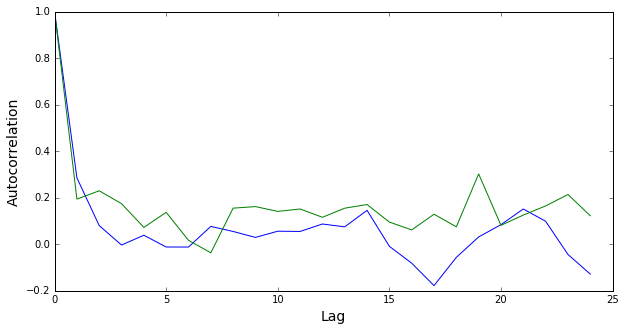

In [151]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))


ax1.plot(range(len(autocorr_returns)), autocorr_returns)
ax1.plot(range(len(autocorr_squared_returns)), autocorr_squared_returns)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 1.2 Fait tails

fat tails of the unconditional distribution
of returns

**How to measure: calculate the powerlaw exponent (alpha)**

In [152]:
h = sorted(list(returns[1:]))
hmean = np.mean(h)
hstd = np.std(h)
pdf = stats.norm.pdf(h, hmean, hstd)
plt.plot(h, pdf)
plt.hist(h, normed=True)

AttributeError: 'list' object has no attribute 'norm'

### Power law exponent / alpha

the tails of the distribution at the shortest time scales were reported to be well-approximated by a powerlaw with exponent α ≈ 3. This tail might be a consequence of powerlaw tails in both the distribution of market order sizes and the instantaneous mid-price logarithmic return impact function. in emerging markets. Dro˙zd˙z et al. (2007) reported that the tails were less heavy (i.e. α > 3).  Longer time scales should lead to a closer and closer approximation by the normal distribution

In [153]:
results = powerlaw.Fit(returns[1:])
print(results.power_law.alpha)

3.42210877504


Calculating best minimal value for power law fit


### 1.3 Clustered volatility

Volatility clustering characterizing their conditional distribution. Probably tied to over-optimism / over pessimism. 

### 1.3.1 Autocorrelation absolute returns 

In [156]:
# one measure for persistent volatility is plotting the autocorrelation of the absolute retunrs
absolute_returns = returns.abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]

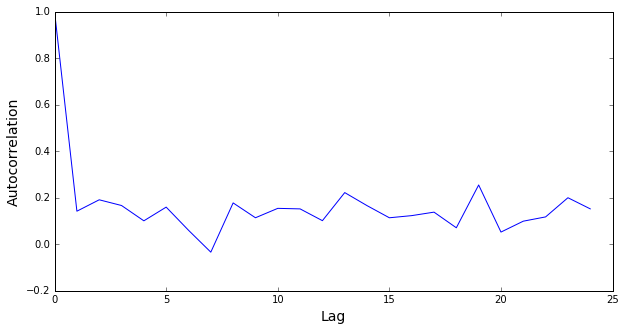

In [157]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 1.3.2 Hurst exponent
How to measure 2: Hurst exponent? 
Gould et al. : Hurst exponent H varied from H ≈ 0.8 on the Paris Bourse and H ≈ 0.815 for the USD/JPY currency pair to H ≈ 0.58 on the Shenzhen Stock Exchange. 
There are several possible explanations for volatility clustering, including the arrival of external news and the strategic splitting of orders by traders (Bouchaud et al. 2009).

In a nutshell, this nifty little number H tells us if a time series is a random walk (H ~ 0.5), trending (H > 0.5) or mean reverting (H < 0.5).

The Hurst code below does not seem to work, better try again using: 

https://robotwealth.com/demystifying-the-hurst-exponent-part-1/

In [32]:
def hurst(price_series, lag1, lag2):
    """
    This is an adaption from:
    https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
    """
    lags = range(lag1, lag2)
    std_differences = [np.sqrt(np.std(np.subtract(price_series[lag:], price_series[:-lag]))) for lag in lags]
    m = np.polyfit(np.log(lags), np.log(std_differences), 1)
    hurst = m[0]*2.0
    return hurst

In [161]:
Hurst = hurst(returns[1:])
Hurst

0.0079228552545837407

In [160]:
Hurst > 0.5

False

## 2 Volume
### 2.1 Large positive autocorrelation

In [162]:
vol = pd.Series(totalvolume)

In [163]:
autocorr_volume = [vol.autocorr(lag=lag) for lag in range(25)]

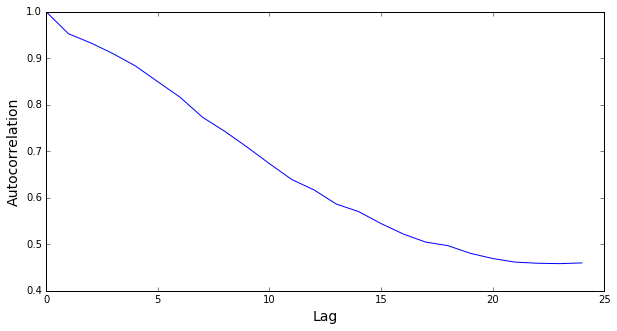

In [164]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(range(len(autocorr_volume)), autocorr_volume)

ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

### 2.2 Correlation between high price volatility and large volumes